# Description
This notebook will experiment with:
- loading of graph classification datasets such as PPI, PROTEINS or ENZYMES
- using GNN for graph classification such as MPNN, GGNN and Graph Nets
Goals:
- how to load and feed the graphs to the models
- how to use GNN models
- compare GNN models
- compare to published results

Most of the experiments will be done in PyTorch/PyTorch Geometric, but some models are implemented in Tensor Flow.

# 0. Codebase

In [76]:
import torch
from torch import Tensor
from torch.nn import Parameter as Param
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import uniform


class GatedGraphConv(MessagePassing):
    r"""The gated graph convolution operator from the `"Gated Graph Sequence
    Neural Networks" <https://arxiv.org/abs/1511.05493>`_ paper

    .. math::
        \mathbf{h}_i^{(0)} &= \mathbf{x}_i \, \Vert \, \mathbf{0}

        \mathbf{m}_i^{(l+1)} &= \sum_{j \in \mathcal{N}(i)} \mathbf{\Theta}
        \cdot \mathbf{h}_j^{(l)}

        \mathbf{h}_i^{(l+1)} &= \textrm{GRU} (\mathbf{m}_i^{(l+1)},
        \mathbf{h}_i^{(l)})

    up to representation :math:`\mathbf{h}_i^{(L)}`.
    The number of input channels of :math:`\mathbf{x}_i` needs to be less or
    equal than :obj:`out_channels`.

    Args:
        out_channels (int): Size of each input sample.
        num_layers (int): The sequence length :math:`L`.
        aggr (string): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"add"`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """

    def __init__(self, out_channels, num_layers, aggr='add', bias=True):
        super(GatedGraphConv, self).__init__(aggr)

        self.out_channels = out_channels
        self.num_layers = num_layers

        self.weight = Param(Tensor(num_layers, out_channels, out_channels))
        self.rnn = torch.nn.GRUCell(out_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        size = self.out_channels
        uniform(size, self.weight)
        self.rnn.reset_parameters()


    def forward(self, x, edge_index):
        """"""
        h = x if x.dim() == 2 else x.unsqueeze(-1)
        assert h.size(1) <= self.out_channels

        if h.size(1) < self.out_channels:
            zero = h.new_zeros(h.size(0), self.out_channels - h.size(1))
            h = torch.cat([h, zero], dim=1)

        for i in range(self.num_layers):
            m = torch.matmul(h, self.weight[i])
            # original master 1.0.3 (new version with problems when using rnn)
            #m = self.propagate(edge_index, x=m)
            # hacky version to use with the pip installation of pytorch-geometric 20190325
            m = self.propagate('add',edge_index, x=m)
            h = self.rnn(m, h)

        return h


    def __repr__(self):
        return '{}({}, num_layers={})'.format(
            self.__class__.__name__, self.out_channels, self.num_layers)


# 1. Models

In [136]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.conv.gated_graph_conv import GatedGraphConv
from torch_geometric.nn.glob.glob import global_mean_pool, global_add_pool
import torch.nn as nn

class Net1(torch.nn.Module):
    def __init__(self, d1=50,d2=20,num_classes=6, num_layers=2, aggr_type='mean'):
        super(Net1, self).__init__()
        self.ggnn = GatedGraphConv(out_channels=d1, num_layers=num_layers,aggr=aggr_type, bias=True)
        self.fc1 = nn.Linear(d1, d2)
        self.fc2 = nn.Linear(d2, num_classes)
        self.global_pool = global_mean_pool
        
        

    def forward(self, data):
        x, edge_index, batch_vector = data.x, data.edge_index, data.batch

        x = self.ggnn(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # until here the output is for each node
        
        x = self.global_pool(x, batch_vector) # this makes the output to be graph level?
        #x = self.fc1(x)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        #x = self.pool1(x, batch )
        x = F.log_softmax(x, dim=1)
        #x = torch.argmax(x, dim=1)  # we output softmax to use the nll_loss
        
        return x
    
class Net2(torch.nn.Module):
    def __init__(self, d1=50,d2=20,num_classes=6, num_layers=2, aggr_type='mean'):
        super(Net2, self).__init__()
        self.ggnn = GatedGraphConv(out_channels=d1, num_layers=num_layers,aggr=aggr_type, bias=True)
        self.fc1 = nn.Linear(d1, num_classes)
        self.global_pool = global_mean_pool
        
    def forward(self, data):
        x, edge_index, batch_vector = data.x, data.edge_index, data.batch

        x = self.ggnn(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # until here the output is for each node
        
        x = self.global_pool(x, batch_vector) # this makes the output to be graph level?
        
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    
class Net3(torch.nn.Module):
    def __init__(self, d1=50,d2=20, d3=10,num_classes=6, num_layers=2, aggr_type='mean'):
        super(Net3, self).__init__()
        self.ggnn = GatedGraphConv(out_channels=d1, num_layers=num_layers,aggr=aggr_type, bias=True)
        self.fc1 = nn.Linear(d1, d2)
        self.dense1_bn = nn.BatchNorm1d(d2)
        self.fc2 = nn.Linear(d2, d3)
        self.dense2_bn = nn.BatchNorm1d(d3)
        self.fc3 = nn.Linear(d3, num_classes)
        self.global_pool = global_mean_pool
        
    def forward(self, data):
        x, edge_index, batch_vector = data.x, data.edge_index, data.batch

        x = self.ggnn(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # until here the output is for each node
        
        x = self.global_pool(x, batch_vector) # this makes the output to be graph level?
        x = F.relu(self.dense1_bn(self.fc1(x)))
        x = F.relu(self.dense2_bn(self.fc2(x)))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
class Net4(torch.nn.Module):
    def __init__(self, d1=50,d2=20,num_classes=6, num_layers=2, aggr_type='mean'):
        super(Net4, self).__init__()
        self.ggnn = GatedGraphConv(out_channels=d1, num_layers=num_layers,aggr=aggr_type, bias=True)
        self.fc1 = nn.Linear(d1, d2)
        self.dense1_bn = nn.BatchNorm1d(d2)
        self.fc2 = nn.Linear(d2, num_classes)
        self.global_pool = global_mean_pool
        
        

    def forward(self, data):
        x, edge_index, batch_vector = data.x, data.edge_index, data.batch

        x = self.ggnn(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # until here the output is for each node
        
        x = self.global_pool(x, batch_vector) # this makes the output to be graph level?
        #x = self.fc1(x)
        x = F.relu(self.dense1_bn(self.fc1(x)))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        #x = self.pool1(x, batch )
        x = F.log_softmax(x, dim=1)
        #x = torch.argmax(x, dim=1)  # we output softmax to use the nll_loss
        
        return x

In [137]:
# models for hyperparameter search
model_list =[
    {'epochs': 200,
    'model': Net1,
    'kwargs':{'d1': 50,'d2': 20,'num_layers':2, 'aggr_type':'mean'}},
    {'epochs': 100,
    'model': Net1,
    'kwargs':{'d1': 50,'d2': 20,'num_layers':2, 'aggr_type':'mean'}},
    {'epochs': 200,
    'model': Net1,
    'kwargs':{'d1': 50,'d2': 20,'num_layers':2, 'aggr_type':'add'}},
    {'epochs': 100,
    'model': Net1,
    'kwargs':{'d1': 50,'d2': 20,'num_layers':2, 'aggr_type':'add'}},
    
    {'epochs': 200,
    'model': Net1,
    'kwargs':{'d1': 100,'d2': 20,'num_layers':2, 'aggr_type':'mean'}},
    {'epochs': 100,
    'model': Net1,
    'kwargs':{'d1': 100,'d2': 20,'num_layers':2, 'aggr_type':'mean'}},
    {'epochs': 200,
    'model': Net1,
    'kwargs':{'d1': 100,'d2': 50,'num_layers':2, 'aggr_type':'mean'}},
    {'epochs': 100,
    'model': Net1,
    'kwargs':{'d1': 100,'d2': 50,'num_layers':2, 'aggr_type':'mean'}},
]

model_list2 = []
for modelclass in [Net1, Net2, Net3,Net4]:
    for d1 in [25,50,100,200]:
        for d2 in [20,50]:
            for aggr_type in ['mean','add']:
                for epochs in [100,200,300]:
                    model_list2.append(
                        {
                        'model': modelclass,
                        'epochs': epochs,
                        'kwargs':{'d1': d1,'d2': d2,'num_layers':2, 
                                  'aggr_type':aggr_type}},
                    )
                    
model_list = model_list2

# 2. Experiments

## 2.1 Load a dataset and use GGNN to classify it (train-test setting)

In [10]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_scatter import scatter_mean
from torch_geometric.data import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

# shuffling dataset
dataset = dataset.shuffle()
#equivalent
#perm = torch.randperm(len(dataset))
#dataset = dataset[perm]

# train-test setting
train_dataset = dataset[:540]
test_dataset = dataset[540:]

print("num_classes:",dataset.num_classes)

# batch feeding
loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
for batch in loader:
    break
    # 32 graphs in each batch
    #batch
    #>>> Batch(x=[1082, 21], edge_index=[2, 4066], y=[32], batch=[1082])
    #print(batch.num_graphs)
    #>>> 32
    
    #print(dir(batch))
    
    # the batch contains batch, a list of where does each node belong 
    #(to whhich graph of the batch does each node belong)
    print(batch.batch)
    #print(batch.test_mask)
    
    #print(dir(batch[0])) # this does not work
    
    # compute avereage node features in the node fimension for each graph individually
    #x = scatter_mean(data.x, data.batch, dim=0)
    #x.size()
    #>>> torch.Size([32, 21])

num_classes: 6


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

#print(dir(F))

for epoch in range(100):
    print("epoch ",epoch)
    for batch in loader:
        #print(" batch num graphs: ",batch.num_graphs)
        #print(" batch num nodes: ", len(batch.x))
        
        data = batch.to(device)
        #print("data.y: ",data.y)

        optimizer.zero_grad()
        out = model(data)
        # how does this work?
        #print(" out: ",out, " out.dim: ", out.dim(), " data.y.dim(): ", data.y.dim())
        #out = out.view(-1,1)
        #target = data.y.view(-1,1)
        target = data.y
        #print(" out: ", out,"\n target: ",target)
        # transform target to a one-hot-encoding
        # output the softmax values for each example
        loss = F.nll_loss(out, target)
        # C = 6, 
        # target (N) means N values, where each value 0<= <= C-1=5
        # out = (N,C) N values/rows of C classes/columns
        #print("loss: ",loss)
        loss.backward()
        optimizer.step()
        
    print(loss)
        
    

epoch  0
tensor(1.8038, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  1
tensor(1.8178, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  2
tensor(1.7949, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  3
tensor(1.8255, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  4
tensor(1.6719, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  5
tensor(1.7289, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  6
tensor(1.6843, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  7
tensor(1.6204, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  8
tensor(1.7464, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  9
tensor(1.7456, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  10
tensor(1.7534, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  11
tensor(1.7968, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  12
tensor(1.6996, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  13
tensor(1.7226, device='cuda:0', grad_fn=<NllLossBackward>)
epoch  14
tensor(1.7017, device='cuda:0', gr

In [12]:
model.eval()

print("len(test_dataset): ", len(test_dataset))
loader = DataLoader(test_dataset, batch_size= len(test_dataset), shuffle=True)
for batch in loader:
    batch = batch.to(device)
    print("num graphs: ", batch.num_graphs)
    #_, pred = model(test_dataset).max(dim=1)
    _, pred = model(batch).max(dim=1)
    print(pred)
    print(batch.y)
    
    correct = pred.eq(batch.y).sum().item()
    #acc = correct / test_dataset.sum().item()
    acc = correct / batch.num_graphs
    print('Accuracy: {:.4f}'.format(acc))  

len(test_dataset):  60
num graphs:  60
tensor([0, 3, 0, 1, 3, 4, 1, 5, 5, 2, 5, 1, 3, 3, 3, 1, 0, 0, 4, 5, 3, 4, 3, 1,
        3, 3, 3, 1, 3, 5, 0, 2, 3, 4, 2, 3, 1, 4, 3, 1, 2, 5, 3, 3, 3, 1, 4, 2,
        1, 3, 4, 3, 4, 5, 4, 2, 3, 5, 5, 3], device='cuda:0')
tensor([0, 2, 1, 5, 3, 1, 4, 4, 3, 2, 5, 1, 3, 2, 2, 1, 3, 4, 1, 5, 3, 3, 4, 0,
        0, 3, 3, 1, 4, 5, 1, 2, 0, 2, 2, 4, 4, 2, 0, 0, 0, 5, 4, 0, 0, 5, 0, 2,
        5, 4, 0, 3, 5, 5, 5, 2, 3, 3, 0, 3], device='cuda:0')
Accuracy: 0.3667


### Results:
1. trained a graph classification model (using global_add_pool)
2. reviewed nll_loss: needs log_softmax on output, and vectors of class id in the target (one-hot enc done insde nll_loss)

### Pending:


## 2.2 Load a dataset and use MPNN to classify it (train-validation-test setting)


In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_scatter import scatter_mean
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

# shuffling dataset
dataset = dataset.shuffle()
#equivalent
#perm = torch.randperm(len(dataset))
#dataset = dataset[perm]

# train-val-test setting
n = len(dataset)
test_lim= int(0.8*n)
val_lim=int(0.8*n*0.7)
train_dataset = dataset[:val_lim]
val_dataset = dataset[val_lim:test_lim]
test_dataset = dataset[test_lim:]
print(" n:",n," val_lim:",val_lim," test_lim:",test_lim)


# batch feeding
loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
loader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)


 n: 600  val_lim: 336  test_lim: 480


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


train_loss_history = []
val_loss_history = []


for epoch in range(200):
    
    model.train()
    loss_train = 0.0
    for batch in loader:
        data = batch.to(device)
        
        optimizer.zero_grad()
        out = model(data)
        target = data.y
        loss = F.nll_loss(out, target)
        loss_train +=loss
        loss.backward()
        optimizer.step()
    loss_train = loss_train / len(train_dataset)
    train_loss_history.append(loss_train.item())
        
    model.eval()
    loss_val = 0.0
    for batch in loader_val:
        data = batch.to(device)
        
        pred = model(batch)
        target = data.y
        loss = F.nll_loss(pred, target)
        loss_val += loss
    loss_val = loss_val / len(val_dataset)
    val_loss_history.append(loss_val.item())
        
    print(" epoch:",epoch," train loss:",loss_train.item()," val loss:", loss_val.item())
        
        
 

 epoch: 0  train loss: 0.058928173035383224  val loss: 0.062085118144750595
 epoch: 1  train loss: 0.0585266537964344  val loss: 0.06184013560414314
 epoch: 2  train loss: 0.05815182626247406  val loss: 0.06170050427317619
 epoch: 3  train loss: 0.05785343423485756  val loss: 0.062231261283159256
 epoch: 4  train loss: 0.05791543796658516  val loss: 0.061325814574956894
 epoch: 5  train loss: 0.05772858113050461  val loss: 0.06141205132007599
 epoch: 6  train loss: 0.057644322514534  val loss: 0.061759836971759796
 epoch: 7  train loss: 0.05713678523898125  val loss: 0.06161436811089516
 epoch: 8  train loss: 0.05711313337087631  val loss: 0.06190349534153938
 epoch: 9  train loss: 0.05724392086267471  val loss: 0.06133158877491951
 epoch: 10  train loss: 0.05697968974709511  val loss: 0.06169113144278526
 epoch: 11  train loss: 0.05740954726934433  val loss: 0.061494164168834686
 epoch: 12  train loss: 0.05702315643429756  val loss: 0.06123407557606697
 epoch: 13  train loss: 0.057079

 epoch: 111  train loss: 0.04774610325694084  val loss: 0.06160545349121094
 epoch: 112  train loss: 0.04807206243276596  val loss: 0.061285700649023056
 epoch: 113  train loss: 0.04802212491631508  val loss: 0.05872964859008789
 epoch: 114  train loss: 0.0464320071041584  val loss: 0.06033194810152054
 epoch: 115  train loss: 0.04734060540795326  val loss: 0.06036359816789627
 epoch: 116  train loss: 0.04745844379067421  val loss: 0.06060352548956871
 epoch: 117  train loss: 0.047824833542108536  val loss: 0.06102550029754639
 epoch: 118  train loss: 0.04683050885796547  val loss: 0.060989294201135635
 epoch: 119  train loss: 0.0471283495426178  val loss: 0.060817766934633255
 epoch: 120  train loss: 0.04654458165168762  val loss: 0.05880863964557648
 epoch: 121  train loss: 0.04648607596755028  val loss: 0.05892401188611984
 epoch: 122  train loss: 0.045622941106557846  val loss: 0.05947423726320267
 epoch: 123  train loss: 0.04594486579298973  val loss: 0.05981556698679924
 epoch: 1

Text(0.5, 1.0, 'Train & validation loss')

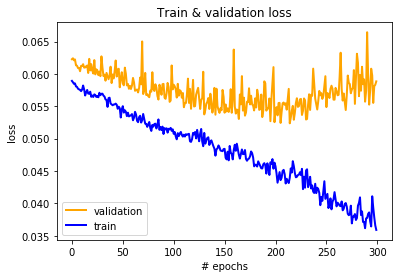

In [28]:
# plot evolution of validation and training loss
#plt.plot(val_loss_history, color = 'orange', linewidth = 2, label='validation')
#plt.plot(train_loss_history, color = 'blue', linewidth = 2,label='train')

#plt.legend()
#plt.xlabel('# epochs')
#plt.ylabel('loss')
#plt.title('Train & validation loss')

# with 300 epochs

Text(0.5, 1.0, 'Train & validation loss')

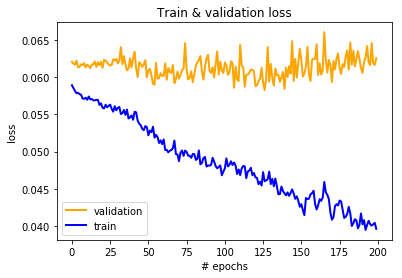

In [7]:
# plot evolution of validation and training loss
plt.plot(val_loss_history, color = 'orange', linewidth = 2, label='validation')
plt.plot(train_loss_history, color = 'blue', linewidth = 2,label='train')

plt.legend()
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.title('Train & validation loss')
   

In [24]:
# now hyper parameter search
# using hold out validation
import numpy as np

def train_model(model, loader, optimizer, train_loss_history):
    model.train()
    loss_train = 0.0
    for batch in loader:
        data = batch.to(device)
        
        optimizer.zero_grad()
        out = model(data)
        target = data.y
        loss = F.nll_loss(out, target)
        loss_train +=loss
        loss.backward()
        optimizer.step()
    loss_train = loss_train / len(train_dataset)
    train_loss_history.append(loss_train.item()) 
    
def val_loss_model(model, loader, optimizer, val_loss_history):
    model.eval()
    loss_val = 0.0
    for batch in loader_val:
        data = batch.to(device)

        pred = model(batch)
        target = data.y
        loss = F.nll_loss(pred, target)
        loss_val += loss
    loss_val = loss_val / len(val_dataset)
    val_loss_history.append(loss_val.item())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for modeldict in model_list:
    
    epochs = modeldict['epochs']
    modelclass = modeldict['model']
    kwargs = modeldict['kwargs']
    model = modelclass(**kwargs)
    model = model.to(device)
    train_loss_history = []
    val_loss_history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    for epoch in range(epochs):
        train_model(model, loader, optimizer, train_loss_history)
        val_loss_model(model, loader, optimizer, val_loss_history)
    print(" trained model: ",modeldict['model'].__name__,
          modeldict['kwargs'], " epochs:",modeldict['epochs'],
          " train loss=",train_loss_history[-1],
         ' val loss=',val_loss_history[-1])


    # save results
    modeldict['train_loss_history']=train_loss_history
    modeldict['val_loss_history']=val_loss_history
    modeldict['val_loss']=val_loss_history[-1]
    
    
# select the best model (lower validation loss)
losses = np.array([ modeldict['val_loss'] for modeldict in model_list])
best_model = model_list[np.argmin(losses)]
print(" selected model: ",best_model['model'].__name__,best_model['kwargs']," epochs:", best_model['epochs'])


 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100  train loss= 0.003927695099264383  val loss= 0.07085386663675308
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200  train loss= 0.0030185796786099672  val loss= 0.08857820928096771
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 300  train loss= 0.0020953130442649126  val loss= 0.09912322461605072
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 100  train loss= 0.004011702723801136  val loss= 0.06972889602184296
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 200  train loss= 0.0029853968881070614  val loss= 0.08465660363435745
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 300  train loss= 0.002010883530601859  val loss= 0.1149858757853508
 trained model:  Net1 {'d1': 25, 'd2': 50, 'num

 trained model:  Net2 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 200  train loss= 0.003232327988371253  val loss= 0.07380946725606918
 trained model:  Net2 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 300  train loss= 0.003187831724062562  val loss= 0.07735157757997513
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100  train loss= 0.004144119564443827  val loss= 0.06473288685083389
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200  train loss= 0.003744367742910981  val loss= 0.06798547506332397
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 300  train loss= 0.003187453141435981  val loss= 0.07639195024967194
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 100  train loss= 0.004365058615803719  val loss= 0.06653944402933121
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_l

 trained model:  Net3 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 300  train loss= 0.0002918201207648963  val loss= 0.15249493718147278
 trained model:  Net3 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 100  train loss= 0.002508194651454687  val loss= 0.08254978805780411
 trained model:  Net3 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 200  train loss= 0.0009239904466085136  val loss= 0.12770617008209229
 trained model:  Net3 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 300  train loss= 0.00039028271567076445  val loss= 0.14154396951198578
 trained model:  Net3 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100  train loss= 0.002130968263372779  val loss= 0.086735300719738
 trained model:  Net3 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200  train loss= 0.0007876470917835832  val loss= 0.11744284629821777
 trained model:  Net3 {'d1': 50, 'd2': 20, 'nu

 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100  train loss= 0.002560235094279051  val loss= 0.08519311994314194
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200  train loss= 0.0009003120940178633  val loss= 0.13351081311702728
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 300  train loss= 0.0003893607354257256  val loss= 0.13447387516498566
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 100  train loss= 0.002418855670839548  val loss= 0.09221427142620087
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 200  train loss= 0.0010786282364279032  val loss= 0.1284964233636856
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 300  train loss= 0.00048094106023199856  val loss= 0.15751582384109497
 trained model:  Net4 {'d1': 50, 'd2': 50, 'n

In [25]:
model = best_model['model']
modelclass = best_model['model']
kwargs = best_model['kwargs']
model = modelclass(**kwargs)
model = model.to(device)
model.eval()

print("len(test_dataset): ", len(test_dataset))
loader = DataLoader(test_dataset, batch_size= len(test_dataset), shuffle=True)
for batch in loader:
    batch = batch.to(device)
    print("num graphs: ", batch.num_graphs)
    #_, pred = model(test_dataset).max(dim=1)
    _, pred = model(batch).max(dim=1)
    print(pred)
    print(batch.y)
    
    correct = pred.eq(batch.y).sum().item()
    #acc = correct / test_dataset.sum().item()
    acc = correct / batch.num_graphs
    print('Accuracy: {:.4f}'.format(acc))  

len(test_dataset):  120
num graphs:  120
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([3, 2, 1, 0, 2, 3, 5, 0, 4, 3, 4, 0, 2, 4, 4, 4, 1, 1, 0, 5, 5, 4, 3, 3,
        1, 2, 5, 0, 1, 0, 3, 0, 3, 1, 4, 4, 4, 3, 1, 0, 4, 3, 0, 1, 4, 2, 1, 1,
        1, 2, 1, 3, 1, 3, 1, 5, 5, 2, 2, 0, 3, 2, 1, 1, 1, 4, 0, 0, 1, 0, 5, 4,
        2, 2, 4, 1, 2, 5, 1, 4, 4, 3, 3, 1, 5, 4, 1, 5, 2, 4, 5, 3, 3, 1, 3, 3,
        1, 1, 2, 5, 5, 0, 3, 0, 5, 2, 4, 2, 0, 3, 5, 5, 5, 0, 1, 1, 3, 2, 2, 5],
       device='cuda:0')
Accuracy: 0.2250


### Results:
1. implemented a validation procedure and plotted train and val loss
2. encapsulated train and validation (hold-out validation)
3. implemente hyperparameter search and model selection
### Pending:
- implement K-fold cross validation? (train model and validate k times for the k folds!)

## 2.3 k-fold Cross validation w dataset balancing

In [79]:
# k-fold cross-validation

import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_scatter import scatter_mean
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# count how many graphs of each class in the dataset
def printDatasetBalance(dataset):
    num_classes = dataset.num_classes
    class_counts = { i:0 for i in range(num_classes)}
    #print(class_counts)
    for graph in dataset:
        class_counts[int(graph.y.item())]+=1
    print(class_counts)
    
    
def balancedDatasetSplit_list(dataset, prop):
    
    dataset = dataset.shuffle()
    n = len(dataset)
    test_lim= int(prop*n)
    num_classes = dataset.num_classes
    
    train_dataset = []
    test_dataset = []
    datasets_byclass = {i:[] for i in range(num_classes)}
    
    
    # for each class repeat balanced split
    for graph in dataset:
        datasets_byclass[int(graph.y.item())].append(graph)
    
    for c in range(num_classes):
        nc = len(datasets_byclass[c])
        limit = int(prop*nc)
        train_dataset.extend(datasets_byclass[c][:limit])
        test_dataset.extend(datasets_byclass[c][limit:])
        
    return train_dataset, test_dataset

    
def balancedDatasetSplit_slice(dataset, prop):
    
    #dataset = dataset.shuffle()
    n = len(dataset)
    test_lim= int(prop*n)
    num_classes = dataset.num_classes
    
    x=torch.Tensor([True,False,True])==True

    train_list = []
    test_list = []
    train_dataset_slice = [False]*n
    test_dataset_slice = [False]*n
    datasets_byclass = {i:[] for i in range(num_classes)}
    
    #print("train_dataset_slice", train_dataset_slice)
    #print("test_dataset_slice", test_dataset_slice)
    #print("datasets_byclass", datasets_byclass)
    
    # for each class repeat balanced split
    for i in range(n):
        graph = dataset[i]
        datasets_byclass[int(graph.y.item())].append(i)

    #print("datasets_byclass",datasets_byclass)
        
    for c in range(num_classes):
        nc = len(datasets_byclass[c])
        limit = int(prop*nc)
        train_list.extend(datasets_byclass[c][:limit])
        test_list.extend(datasets_byclass[c][limit:])
        
    #print("train_list", train_list)
    #print("test_list", test_list)

        
    # now from list of integers(indices) to boolean mask tensor
    #for i in range(len(train_list)):
    #    real_index = train_list[i]
    #    train_dataset_slice[real_index] = True
        
    #for i in range(len(test_list)):
    #    real_index = test_list[i]
    #    test_dataset_slice[real_index] = True
        
    #print("train_dataset_slice", train_dataset_slice)
    #print("test_dataset_slice", test_dataset_slice)
        
    train_dataset = dataset[torch.LongTensor(train_list)]
    test_dataset = dataset[torch.LongTensor(test_list)]
        
    #print("train_dataset", train_dataset)
    #print("test_dataset", test_dataset)
    
    return train_dataset, test_dataset


def balancedDatasetKfoldSplit_slice(dataset,k):
    
    #dataset = dataset.shuffle()
    n = len(dataset)
    
    foldsize = int(n/k)
    num_classes = dataset.num_classes
    num_items_x_class = int(foldsize/num_classes)
    
    # list of items for each class
    train_list = []
    test_list = []
    datasets_byclass = {i:[] for i in range(num_classes)}
    for i in range(n):
        graph = dataset[i]
        datasets_byclass[int(graph.y.item())].append(i)

    #print(datasets_byclass)
    
    folds = []
    for i in range(k):
        folds.append([])
        for c in range(num_classes):
            for j in range(num_items_x_class):
                index = datasets_byclass[c].pop()
                folds[i].append(index)
        
    # returns a list of list of indices
    return folds

def kFolding(train_dataset, k):
    n = len(train_dataset)
    fold_size = int(n/k)
    
    # build folds
    #folds = []
    #for i in range(k):
    #    i1 = i*fold_size
    #    i2 = i1+fold_size
    #    folds.append((i1,i2))
    #print(folds)
    
    # build train-val sets
    train_sets =[]
    for i in range(k):
        preval_index = (0,i*fold_size)
        val_index = (i*fold_size,i*fold_size+fold_size)
        postval_index = (i*fold_size+fold_size,n)
        train_sets.append((preval_index, val_index, postval_index))
        
    #print(train_sets)
    return train_sets

def kFolding2(train_dataset, k):

    #print(" train_dataset len:", len(train_dataset))
    folds = balancedDatasetKfoldSplit_slice(train_dataset, k)
    train_sets =[]
    for i in range(k):
        # each train_set must have a torch.LongTensor for train indices
        # and a torch.LongTensor for val indices
        val_merge = folds[i]
        train_merge = [] 
        for j in range(k):
            if j != i:
                train_merge.extend(folds[j])
        train_sets.append((torch.LongTensor(train_merge), torch.LongTensor(val_merge)))
    
    return train_sets
    


def accuracy(pred, batch):
    correct = pred.eq(batch.y).sum().item()
    #acc = correct / test_dataset.sum().item()
    acc = correct / batch.num_graphs
    return acc



def train_model(model, loader, optimizer, train_loss_history):
    model.train()
    loss_train = 0.0
    total_num_graphs = 0
    for batch in loader:
        data = batch.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = data.y
        loss = F.nll_loss(out, target)
        loss_train +=loss
        loss.backward()
        optimizer.step()
        total_num_graphs += data.num_graphs
        
    loss_train = loss_train /total_num_graphs
    train_loss_history.append(loss_train.item()) 
    
def val_loss_model(model, loader, optimizer, val_loss_history,val_accuracy_history):
    model.eval()
    loss_val = 0.0
    total_num_graphs = 0
    for batch in loader_val:
        data = batch.to(device)
        pred = model(batch)
        _, predacc = pred.max(dim=1)
        target = data.y
        loss = F.nll_loss(pred, target)
        loss_val += loss
        total_num_graphs += data.num_graphs
        
    loss_val = loss_val / total_num_graphs
    val_loss_history.append(loss_val.item())
    val_accuracy_history.append(accuracy(predacc, batch))
    
    
def final_model_train(modeldict, train_dataset):
    epochs = modeldict['epochs']
    modelclass = modeldict['model']
    kwargs = modeldict['kwargs']
    model = modelclass(**kwargs)
    model = model.to(device)
    train_loss_history=[]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    for epoch in range(epochs):
        train_model(model, loader, optimizer, train_loss_history)
        
    return model

# Retrain the best model
def final_model_train(modeldict, train_dataset):
    epochs = modeldict['epochs']
    modelclass = modeldict['model']
    kwargs = modeldict['kwargs']
    model = modelclass(**kwargs)
    model = model.to(device)
    train_loss_history=[]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    for epoch in range(epochs):
        train_model(model, loader, optimizer, train_loss_history)
        
    return model




In [80]:

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

# shuffling dataset
dataset = dataset.shuffle()

# train-val-test setting
k = 3
train_dataset, test_dataset = balancedDatasetSplit_slice(dataset, prop=0.8)

print(" n:",n," k folds=",k," test_lim:",test_lim)


    
#train_dataset = dataset[:test_lim]
#test_dataset = dataset[test_lim:]
printDatasetBalance(dataset )
printDatasetBalance(train_dataset )
printDatasetBalance(test_dataset )

# amazingly enough the datasets appear to be in balance

 n: 600  k folds= 3  test_lim: 480
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
{0: 80, 1: 80, 2: 80, 3: 80, 4: 80, 5: 80}
{0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20}


In [81]:



    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


kfolds = kFolding2(train_dataset,k)
#print("kfolds",kfolds)

for modeldict in model_list:

    epochs = modeldict['epochs']
    modelclass = modeldict['model']
    kwargs = modeldict['kwargs']
    model = modelclass(**kwargs)
    model = model.to(device)
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    modeldict['cv_val_loss']=0.0
    modeldict['cv_val_accuracy']=0.0
    
    for kfold in kfolds:
        
        # train-val for each fold configuration
        #train1 = []
        #train2 = []
        #if kfold[0][0] != kfold[0][1]:
        #    train1 = list(range(kfold[0][0],kfold[0][1])) 
        #if kfold[2][0] != kfold[2][1]:
        #    train2 = list(range(kfold[2][0],kfold[2][1]))
        #    
        #train1.extend(train2)
        #train_subset = torch.LongTensor(train1)
        # 
        #train = train_dataset[train_subset]
        #val = train_dataset[kfold[1][0]:kfold[1][1]] 
        
        train = train_dataset[kfold[0]]
        val = train_dataset[kfold[1]]
        
        #print("train balance")
        #printDatasetBalance(train)
        #print("val balance")
        #printDatasetBalance(val )
        
        loader = DataLoader(train, batch_size=32, shuffle=True)
        loader_val = DataLoader(val, batch_size=32, shuffle=True)

        for epoch in range(epochs):
            train_model(model, loader, optimizer, train_loss_history)
            val_loss_model(model, loader_val, optimizer, val_loss_history, val_accuracy_history)

        # save results
        modeldict['train_loss_history']=train_loss_history
        modeldict['val_loss_history']=val_loss_history
        modeldict['val_accuracy_history']=val_accuracy_history
        modeldict['val_loss']=val_loss_history[-1]
        modeldict['accuracy']=val_accuracy_history[-1]
        modeldict['cv_val_loss']+=modeldict['val_loss']
        modeldict['cv_val_accuracy']+=modeldict['accuracy']
        
    modeldict['cv_val_loss']=modeldict['cv_val_loss']/len(kfolds)
    modeldict['cv_val_accuracy']=modeldict['cv_val_accuracy']/len(kfolds)
    print(" trained model: ",modeldict['model'].__name__,
              modeldict['kwargs'], " epochs:",modeldict['epochs'],
             ' val loss=',modeldict['cv_val_loss'],
          ' val accuracy=',modeldict['cv_val_accuracy'])
        
    


 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100  val loss= 0.05130531763037046  val accuracy= 0.42857142857142855
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200  val loss= 0.05099687104423841  val accuracy= 0.5476190476190476
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 300  val loss= 0.054085383812586464  val accuracy= 0.4047619047619047
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 100  val loss= 0.05210575337211291  val accuracy= 0.42857142857142855
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 200  val loss= 0.05031448105971018  val accuracy= 0.4047619047619047
 trained model:  Net1 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 300  val loss= 0.05583833406368891  val accuracy= 0.4166666666666667
 trained model:  Net1 {'d1': 25, 'd2': 50, 'nu

 trained model:  Net2 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 200  val loss= 0.05039196337262789  val accuracy= 0.3333333333333333
 trained model:  Net2 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 300  val loss= 0.05208001285791397  val accuracy= 0.4166666666666667
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100  val loss= 0.05252468213438988  val accuracy= 0.3333333333333333
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200  val loss= 0.050344448536634445  val accuracy= 0.42857142857142855
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 300  val loss= 0.052339255809783936  val accuracy= 0.3928571428571428
 trained model:  Net2 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 100  val loss= 0.05269894003868103  val accuracy= 0.4404761904761905
 trained model:  Net2 {'d1': 25, 'd2': 50, 'nu

 trained model:  Net3 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 300  val loss= 0.049372024834156036  val accuracy= 0.5119047619047619
 trained model:  Net3 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 100  val loss= 0.0523978074391683  val accuracy= 0.4047619047619048
 trained model:  Net3 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 200  val loss= 0.05201594283183416  val accuracy= 0.4761904761904762
 trained model:  Net3 {'d1': 25, 'd2': 50, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 300  val loss= 0.05428477500875791  val accuracy= 0.5357142857142857
 trained model:  Net3 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100  val loss= 0.05149538069963455  val accuracy= 0.4047619047619048
 trained model:  Net3 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200  val loss= 0.05549837897221247  val accuracy= 0.36904761904761907
 trained model:  Net3 {'d1': 50, 'd2': 20, 'num_

 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100  val loss= 0.05115327859918276  val accuracy= 0.4761904761904762
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200  val loss= 0.05443843578298887  val accuracy= 0.46428571428571425
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 300  val loss= 0.05347987885276476  val accuracy= 0.5119047619047619
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 100  val loss= 0.051838941872119904  val accuracy= 0.36904761904761907
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 200  val loss= 0.053514706591765084  val accuracy= 0.45238095238095233
 trained model:  Net4 {'d1': 50, 'd2': 20, 'num_layers': 2, 'aggr_type': 'add'}  epochs: 300  val loss= 0.062047707537810005  val accuracy= 0.5357142857142857
 trained model:  Net4 {'d1': 50, 'd2': 50, 

In [82]:
# select the best model (lower validation loss)
losses = np.array([ modeldict['cv_val_loss'] for modeldict in model_list])
accuracies = np.array([ modeldict['cv_val_accuracy'] for modeldict in model_list])
best_model_loss = model_list[np.argmin(losses)]
best_model_acc = model_list[np.argmax(accuracies)]
print(" selected model from loss: ",best_model_loss['model'].__name__,best_model_loss['kwargs']," epochs:", 
      best_model_loss['epochs'], best_model_loss['cv_val_loss'], best_model_loss['cv_val_accuracy'])
print(" selected model from accuracy: ",best_model_acc['model'].__name__,best_model_acc['kwargs']," epochs:", 
      best_model_acc['epochs'],  best_model_acc['cv_val_loss'], best_model_acc['cv_val_accuracy'])
best_model = best_model_acc

 selected model from loss:  Net4 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 100 0.04821902513504028 0.5
 selected model from accuracy:  Net4 {'d1': 25, 'd2': 20, 'num_layers': 2, 'aggr_type': 'mean'}  epochs: 200 0.04856414472063383 0.6547619047619048


In [83]:
best_model = best_model_loss
best_model = best_model_acc

In [84]:

model = final_model_train(best_model, train_dataset)

In [85]:

model.eval()

print("len(test_dataset): ", len(test_dataset))
loader = DataLoader(test_dataset, batch_size= len(test_dataset), shuffle=True)
for batch in loader:
    batch = batch.to(device)
    print("num graphs: ", batch.num_graphs)
    #_, pred = model(test_dataset).max(dim=1)
    _, pred = model(batch).max(dim=1)
    print(pred)
    print(batch.y)
    
    acc = accuracy(pred, batch)
    print('Accuracy: {:.4f}'.format(acc))  

len(test_dataset):  120
num graphs:  120
tensor([5, 4, 3, 2, 0, 5, 4, 0, 4, 2, 0, 4, 1, 3, 3, 5, 5, 3, 3, 0, 4, 5, 1, 1,
        5, 4, 1, 5, 2, 2, 0, 4, 0, 3, 5, 1, 2, 4, 4, 2, 0, 5, 5, 2, 0, 4, 1, 3,
        0, 4, 4, 4, 2, 2, 4, 4, 5, 2, 1, 4, 3, 5, 2, 4, 5, 4, 2, 5, 2, 4, 0, 1,
        0, 1, 0, 2, 3, 0, 2, 2, 2, 4, 3, 2, 0, 2, 2, 1, 3, 0, 5, 5, 4, 0, 5, 0,
        2, 3, 5, 5, 0, 5, 5, 1, 4, 3, 4, 1, 1, 3, 0, 0, 5, 3, 2, 4, 3, 5, 4, 1],
       device='cuda:0')
tensor([4, 3, 3, 2, 1, 5, 0, 4, 4, 0, 2, 3, 1, 4, 3, 5, 5, 4, 3, 0, 5, 5, 0, 0,
        5, 2, 1, 0, 1, 2, 2, 4, 5, 0, 5, 1, 0, 0, 0, 2, 0, 5, 5, 2, 0, 1, 1, 4,
        0, 3, 2, 4, 2, 1, 0, 4, 5, 2, 1, 1, 3, 1, 2, 4, 5, 4, 2, 3, 4, 4, 4, 3,
        0, 0, 3, 2, 3, 1, 2, 5, 2, 4, 3, 2, 1, 1, 2, 1, 3, 0, 5, 1, 3, 1, 0, 0,
        2, 3, 5, 5, 0, 3, 5, 1, 1, 3, 3, 2, 2, 3, 5, 4, 4, 4, 4, 4, 3, 1, 5, 5],
       device='cuda:0')
Accuracy: 0.5250


### Results:
1. implemented K-fold cross validation? (train model and validate k times for the k folds!)
2. Fixed - review  whyy predict is NOT DETERMINISTIC -> final retraining after model selection
3. implemented dataset balancing: accuracy raised from 38%-40% to 52%


### Pending:



## 2.3 Implement the F1 scores and cross-validate with F1 Score

In [138]:
# compute PRE, REC and F1
def PRE(measuresdict):
    m = measuresdict
    measuresdict['PRE'] = float(m['TP'])/float(m['TP']+m['FP'])
    
def REC(m):
    m['REC'] = float(m['TP'])/float(m['FN']+m['TP'])

def F1(m):
    m['F1']=2.0*(m['PRE']*m['REC'])/(m['PRE']+m['REC'])
    
def macroAndMicroScores(m):
    # average all precisions
    # average all recalls
    # compute macroF1
    macroPRE = 0.0
    macroREC = 0.0
    num_classes = 0
    microPREnumerator = 0.0
    microPREdenominator = 0.0
    microRECnumerator = 0.0
    microRECdenominator = 0.0
    for k,v in m.items():
        try:
            a = int(k)
            macroPRE+=m[k]['PRE']
            macroREC+=m[k]['REC']
            
            microPREnumerator+=m[k]['TP']
            microPREdenominator+=m[k]['TP']
            microPREdenominator+=m[k]['FP']
            
            microRECnumerator+=m[k]['TP']
            microRECdenominator+=m[k]['TP']
            microRECdenominator+=m[k]['FN']
            
            num_classes+=1
        except:
            # only keys related to classes
            # avoid macro and micro keys
            pass
        
    macroPRE = macroPRE/float(num_classes)
    macroREC = macroREC/float(num_classes)
    macroF1 = 2.0*(macroPRE*macroREC)/(macroPRE+macroREC)
    m['macroPRE'] = macroPRE
    m['macroREC'] = macroREC
    m['macroF1'] = macroF1
    
    microPRE = microPREnumerator/microPREdenominator
    microREC = microRECnumerator/microRECdenominator
    microF1 = 2.0*(microPRE*microREC)/(microPRE+microREC)
    m['microPRE'] = microPRE
    m['microREC'] = microREC
    m['microF1'] = microF1
    

def F1Score(pred, target):
    predset = set(pred)
    targetset = set(target)
    #print(predset)
    #print(targetset)
    num_classes = max(len(predset),len(targetset))

    # for each class save pred_indices, and target_indices
    preddict = { i:[] for i in range(num_classes) }
    targetdict = { i:[] for i in range(num_classes) }
    #print(preddict)

    for i in range(len(pred)):
        preddict[pred[i]].append(i)
        targetdict[target[i]].append(i)

    #print("preddict", preddict)
    #print("targetdict", targetdict)

    measures = { 
        i:{'TP':0, 'TN':0, 'FP':0, 
           'FN':0, 'PRE':0.0, 'REC': 0.0, 'F1':0.0} 
        for i in range(num_classes)}
    for i in range(num_classes):
        for j in range(len(preddict[i])):
            if preddict[i][j] in targetdict[i]:
                measures[i]['TP']+=1
            else:
                measures[i]['FP']+=1

        for j in range(len(targetdict[i])):
            if targetdict[i][j] not in preddict[i]:
                measures[i]['FN']+=1

        for j in range(len(pred2)):
            if pred2[j] not in preddict[i] and pred2[j] not in targetdict[i]:
                measures[i]['TN']+=1

    #print(" single measures",measures)
    for k,mdict in measures.items():
        try:
            PRE(mdict)
        except:
            #print("could not compute PRE on class ",k)
            pass
        try:
            REC(mdict)
        except:
            #print("could not compute REC on class ",k)
            pass
        try:
            F1(mdict)
        except:
            #print("could not compute F1 on class ",k)
            pass

    macroAndMicroScores(measures)

    return measures




In [139]:
# k-fold cross-validation

import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_scatter import scatter_mean
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# count how many graphs of each class in the dataset
def printDatasetBalance(dataset):
    num_classes = dataset.num_classes
    class_counts = { i:0 for i in range(num_classes)}
    #print(class_counts)
    for graph in dataset:
        class_counts[int(graph.y.item())]+=1
    print(class_counts)
    
    
def balancedDatasetSplit_list(dataset, prop):
    
    dataset = dataset.shuffle()
    n = len(dataset)
    test_lim= int(prop*n)
    num_classes = dataset.num_classes
    
    train_dataset = []
    test_dataset = []
    datasets_byclass = {i:[] for i in range(num_classes)}
    
    
    # for each class repeat balanced split
    for graph in dataset:
        datasets_byclass[int(graph.y.item())].append(graph)
    
    for c in range(num_classes):
        nc = len(datasets_byclass[c])
        limit = int(prop*nc)
        train_dataset.extend(datasets_byclass[c][:limit])
        test_dataset.extend(datasets_byclass[c][limit:])
        
    return train_dataset, test_dataset

    
def balancedDatasetSplit_slice(dataset, prop):
    
    #dataset = dataset.shuffle()
    n = len(dataset)
    test_lim= int(prop*n)
    num_classes = dataset.num_classes
    
    x=torch.Tensor([True,False,True])==True

    train_list = []
    test_list = []
    train_dataset_slice = [False]*n
    test_dataset_slice = [False]*n
    datasets_byclass = {i:[] for i in range(num_classes)}
    
    #print("train_dataset_slice", train_dataset_slice)
    #print("test_dataset_slice", test_dataset_slice)
    #print("datasets_byclass", datasets_byclass)
    
    # for each class repeat balanced split
    for i in range(n):
        graph = dataset[i]
        datasets_byclass[int(graph.y.item())].append(i)

    #print("datasets_byclass",datasets_byclass)
        
    for c in range(num_classes):
        nc = len(datasets_byclass[c])
        limit = int(prop*nc)
        train_list.extend(datasets_byclass[c][:limit])
        test_list.extend(datasets_byclass[c][limit:])
        
    #print("train_list", train_list)
    #print("test_list", test_list)

        
    # now from list of integers(indices) to boolean mask tensor
    #for i in range(len(train_list)):
    #    real_index = train_list[i]
    #    train_dataset_slice[real_index] = True
        
    #for i in range(len(test_list)):
    #    real_index = test_list[i]
    #    test_dataset_slice[real_index] = True
        
    #print("train_dataset_slice", train_dataset_slice)
    #print("test_dataset_slice", test_dataset_slice)
        
    train_dataset = dataset[torch.LongTensor(train_list)]
    test_dataset = dataset[torch.LongTensor(test_list)]
        
    #print("train_dataset", train_dataset)
    #print("test_dataset", test_dataset)
    
    return train_dataset, test_dataset


def balancedDatasetKfoldSplit_slice(dataset,k):
    
    #dataset = dataset.shuffle()
    n = len(dataset)
    
    foldsize = int(n/k)
    num_classes = dataset.num_classes
    num_items_x_class = int(foldsize/num_classes)
    
    # list of items for each class
    train_list = []
    test_list = []
    datasets_byclass = {i:[] for i in range(num_classes)}
    for i in range(n):
        graph = dataset[i]
        datasets_byclass[int(graph.y.item())].append(i)

    #print(datasets_byclass)
    
    folds = []
    for i in range(k):
        folds.append([])
        for c in range(num_classes):
            for j in range(num_items_x_class):
                index = datasets_byclass[c].pop()
                folds[i].append(index)
        
    # returns a list of list of indices
    return folds

def kFolding(train_dataset, k):
    n = len(train_dataset)
    fold_size = int(n/k)
    
    # build folds
    #folds = []
    #for i in range(k):
    #    i1 = i*fold_size
    #    i2 = i1+fold_size
    #    folds.append((i1,i2))
    #print(folds)
    
    # build train-val sets
    train_sets =[]
    for i in range(k):
        preval_index = (0,i*fold_size)
        val_index = (i*fold_size,i*fold_size+fold_size)
        postval_index = (i*fold_size+fold_size,n)
        train_sets.append((preval_index, val_index, postval_index))
        
    #print(train_sets)
    return train_sets

def kFolding2(train_dataset, k):

    #print(" train_dataset len:", len(train_dataset))
    folds = balancedDatasetKfoldSplit_slice(train_dataset, k)
    train_sets =[]
    for i in range(k):
        # each train_set must have a torch.LongTensor for train indices
        # and a torch.LongTensor for val indices
        val_merge = folds[i]
        train_merge = [] 
        for j in range(k):
            if j != i:
                train_merge.extend(folds[j])
        train_sets.append((torch.LongTensor(train_merge), torch.LongTensor(val_merge)))
    
    return train_sets
    


def accuracy(pred, batch):
    correct = pred.eq(batch.y).sum().item()
    #acc = correct / test_dataset.sum().item()
    acc = correct / batch.num_graphs
    return acc



def train_model(model, loader, optimizer, train_loss_history):
    model.train()
    loss_train = 0.0
    total_num_graphs = 0
    for batch in loader:
        data = batch.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = data.y
        loss = F.nll_loss(out, target)
        loss_train +=loss
        loss.backward()
        optimizer.step()
        total_num_graphs += data.num_graphs
        
    loss_train = loss_train /total_num_graphs
    train_loss_history.append(loss_train.item()) 
    
def val_loss_model(model, loader, optimizer, val_history):
    model.eval()
    loss_val = 0.0
    total_num_graphs = 0
    total_pred = []
    total_acc = []
    total_gt = []
    
    for batch in loader_val:
        data = batch.to(device)
        pred = model(batch)
        total_pred.extend(pred.flatten().tolist())
        total_gt.extend(batch.y.flatten().tolist())
        
        _, predacc = pred.max(dim=1)
        total_acc.extend(predacc.flatten().tolist())
        
        target = data.y
        loss = F.nll_loss(pred, target)
        loss_val += loss
        total_num_graphs += data.num_graphs
        
    loss_val = loss_val / total_num_graphs
    val_history['loss'].append(loss_val.item())
    
    # accuracy needs correction
    val_history['accuracy'].append(accuracy(predacc, batch))
    
    # compute F1 scores
    #pred2 = pred.to('cpu')
    #pred2 = pred2.flatten().tolist()
    #target = batch.y.to('cpu')
    #target = target.flatten().tolist()
    
    #print("total_acc",total_acc)
    #print("total_gt",total_gt)
    measures = F1Score(total_acc, total_gt)
    val_history['microF1'].append(measures['microF1'])
    val_history['macroF1'].append(measures['macroF1'])
    
    
def final_model_train(modeldict, train_dataset):
    epochs = modeldict['epochs']
    modelclass = modeldict['model']
    kwargs = modeldict['kwargs']
    model = modelclass(**kwargs)
    model = model.to(device)
    train_loss_history=[]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    for epoch in range(epochs):
        train_model(model, loader, optimizer, train_loss_history)
        
    return model

# Retrain the best model
def final_model_train(modeldict, train_dataset):
    epochs = modeldict['epochs']
    modelclass = modeldict['model']
    kwargs = modeldict['kwargs']
    model = modelclass(**kwargs)
    model = model.to(device)
    train_loss_history=[]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    for epoch in range(epochs):
        train_model(model, loader, optimizer, train_loss_history)
        
    return model




In [140]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
k = 3
train_dataset, test_dataset = balancedDatasetSplit_slice(dataset, prop=0.8)
print(" n:",n," k folds=",k," test_lim:",test_lim)
printDatasetBalance(dataset )
printDatasetBalance(train_dataset )
printDatasetBalance(test_dataset )

 n: 600  k folds= 3  test_lim: 480
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
{0: 80, 1: 80, 2: 80, 3: 80, 4: 80, 5: 80}
{0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20}


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kfolds = kFolding2(train_dataset,k)

for modeldict in model_list:

    epochs = modeldict['epochs']
    modelclass = modeldict['model']
    kwargs = modeldict['kwargs']
    model = modelclass(**kwargs)
    model = model.to(device)
    train_loss_history = []
    val_history = {'loss':[], 'accuracy':[], 'microF1':[],'macroF1':[]}
    modeldict['cv_val_loss']=0.0
    modeldict['cv_val_accuracy']=0.0
    modeldict['cv_val_microF1'] =0.0
    modeldict['cv_val_macroF1'] =0.0
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for kfold in kfolds:
        
        train = train_dataset[kfold[0]]
        val = train_dataset[kfold[1]]
        loader = DataLoader(train, batch_size=32, shuffle=True)
        loader_val = DataLoader(val, batch_size=32, shuffle=True)
        for epoch in range(epochs):
            train_model(model, loader, optimizer, train_loss_history)
            val_loss_model(model, loader_val, optimizer, val_history)

        # save results
        modeldict['train_loss_history']=train_loss_history
        modeldict['val_loss_history']=val_history['loss']
        modeldict['val_accuracy_history']=val_history['accuracy']
        modeldict['val_loss']=val_history['loss'][-1]
        modeldict['accuracy']=val_history['accuracy'][-1]
        modeldict['microF1']=val_history['microF1'][-1]
        modeldict['macroF1']=val_history['macroF1'][-1]
        
        modeldict['cv_val_loss']+=modeldict['val_loss']
        modeldict['cv_val_accuracy']+=modeldict['accuracy']
        modeldict['cv_val_microF1']+=modeldict['microF1']
        modeldict['cv_val_macroF1']+=modeldict['macroF1']
        
    modeldict['cv_val_loss']=modeldict['cv_val_loss']/len(kfolds)
    modeldict['cv_val_accuracy']=modeldict['cv_val_accuracy']/len(kfolds)
    modeldict['cv_val_microF1']=modeldict['cv_val_microF1']/len(kfolds)
    modeldict['cv_val_macroF1']=modeldict['cv_val_macroF1']/len(kfolds)
    print(" trained model: ",modeldict['model'].__name__,
              modeldict['kwargs'], " epochs:",modeldict['epochs'],
             ' val loss=',modeldict['cv_val_loss'],
          ' val accuracy=',modeldict['cv_val_accuracy'],
         ' val microF1=',modeldict['cv_val_microF1'],
          ' val macroF1=',modeldict['cv_val_macroF1'])

In [ ]:
# select the best model (lower validation loss)
losses = np.array([ modeldict['cv_val_loss'] for modeldict in model_list])
accuracies = np.array([ modeldict['cv_val_accuracy'] for modeldict in model_list])
microF1 = np.array([ modeldict['cv_val_microF1'] for modeldict in model_list])
macroF1 = np.array([ modeldict['cv_val_macroF1'] for modeldict in model_list])
best_model_loss = model_list[np.argmin(losses)]
best_model_acc = model_list[np.argmax(accuracies)]
best_model_microF1 = model_list[np.argmin(microF1)]
best_model_macroF1 = model_list[np.argmax(macroF1)]

print(" selected model from loss: ",best_model_loss['model'].__name__,
      best_model_loss['kwargs']," epochs:", best_model_loss['epochs'], 
      best_model_loss['cv_val_loss'], best_model_loss['cv_val_accuracy'], 
      best_model_loss['cv_val_microF1'], best_model_loss['cv_val_macroF1'])
print(" selected model from accuracy: ",best_model_acc['model'].__name__,
      best_model_acc['kwargs']," epochs:",best_model_acc['epochs'],  
      best_model_acc['cv_val_loss'], best_model_acc['cv_val_accuracy'], 
      best_model_loss['cv_val_microF1'], best_model_loss['cv_val_macroF1'])
print(" selected model from microF1: ",best_model_microF1['model'].__name__,best_model_microF1['kwargs'],
      " epochs:", best_model_microF1['epochs'],  
      best_model_microF1['cv_val_loss'], best_model_microF1['cv_val_accuracy'], 
      best_model_microF1['cv_val_microF1'], best_model_microF1['cv_val_macroF1'])

print(" selected model from macroF1: ",best_model_macroF1['model'].__name__,best_model_macroF1['kwargs'],
      " epochs:", best_model_macroF1['epochs'],  
      best_model_macroF1['cv_val_loss'], best_model_macroF1['cv_val_accuracy'], 
      best_model_macroF1['cv_val_microF1'], best_model_macroF1['cv_val_macroF1'])


In [ ]:
#best_model = best_model_loss
#best_model = best_model_acc
best_model = best_model_microF1
#best_model = best_model_macroF1
model = final_model_train(best_model, train_dataset)

model.eval()
print("len(test_dataset): ", len(test_dataset))
loader = DataLoader(test_dataset, batch_size= len(test_dataset), shuffle=True)
for batch in loader:
    batch = batch.to(device)
    print("num graphs: ", batch.num_graphs)
    #_, pred = model(test_dataset).max(dim=1)
    _, pred = model(batch).max(dim=1)
    print(pred)
    print(batch.y)
    
    acc = accuracy(pred, batch)    
    pred2 = pred.to('cpu')
    pred2 = pred2.flatten().tolist()
    target = batch.y.to('cpu')
    target = target.flatten().tolist()
    measures = F1Score(pred2, target)
    print('Accuracy: {:.4f}'.format(acc)," macroF1:",measures['macroF1'], " microF1:", measures['microF1'])

## 2.4 Load a dataset and use MetaLayer to classify it (train-validation-test setting)

## 2.5 